In [1]:
import tensorflow as tf
import numpy as np
from predictor import Predictor
from models import *
import matplotlib.pyplot as plt
import pandas as pd
import math
from  models import esum2
import random

In [13]:
sample_width = 1
input_width = 16
sections = int(math.log2(input_width))
model =  keras.models.load_model("models/trendencoder")
predictor = Predictor(datafile="datas/EURUSD_H1 copy.csv",model=model,input_width=input_width,label_width=1,sample_width=sample_width,shift=1,train_ratio=0.8,val_ratio=0.1,test_ratio=0.1,batch_size=2**12)


In [31]:
df = pd.read_csv(
    "datas/EURUSD_H1 copy.csv",
    sep="\t",
    nrows=2**16,
    header=0,
    dtype={"open": np.float32,"close": np.float32,"tickvol": np.float32,"vol": np.float32},
    parse_dates=[[0,1]],
    index_col=[0],
    names=["date","time","open","high","low","close","tickvol","vol","spread"])
t_count = 2**7
t_shift = random.randint(0,2**10)
prices = df['open'][-t_count-t_shift:-1-t_shift]
shift = predictor.dataloader.input_width
ds = predictor.dataloader.make_dataset(prices)
for i,l in ds:
    print(i.shape, l.shape)
labels = (l.numpy().flatten()*100000).round(1)
# print(i.numpy()[shift+16:].flatten())
# print(labels)


(107, 16, 1) (107, 1, 1)


1/1 [==============================] - 0s 937us/step


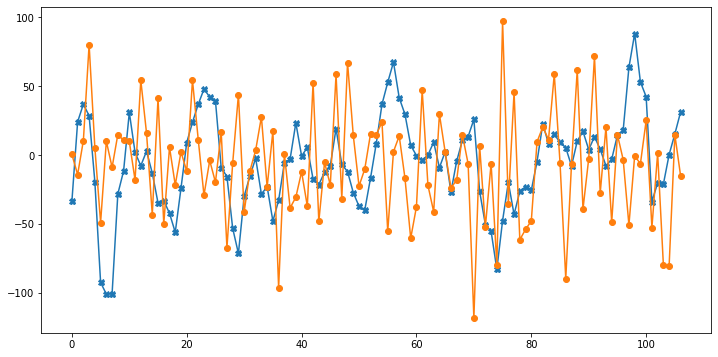

In [32]:
result = predictor.predict(prices)[:-1]
outputs = (result.flatten()*100000).round(1)
t = np.arange(len(result))
plt.subplots(nrows=1, ncols=1,figsize=(12,6))
plt.plot(t,result*100000, marker='X')
plt.plot(t,labels, marker='o')
